In [1]:
#TFG: "Simulación del modelo cuántico de Ising en un ordenador cuántico"
#Autor: Pedro José Álvarez Terraz. 798339@unizar.es || palvarezterraz@gmail.com
#Director: José Vicente García Esteve. Universidad de Zaragoza.

"""
Para ejecutar este código se recomienda Qiskit < 1.0
Si se utiliza un Qiskit de versión mayor (Qiskit >=1.0) da errores para el método QuantumCircuit.execute() y también para Aer.
"""

'\nPara ejecutar este código se recomienda Qiskit < 1.0\nSi se utiliza un Qiskit de versión mayor (Qiskit >=1.0) da errores para el método QuantumCircuit.execute() y también para Aer.\n'

In [2]:
#PARÁMETROS GENERALES, LIBRERÍAS Y SUBRUTINAS.

#Librerias y funciones
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
import datetime as dt
from os import mkdir, makedirs

print("Hora comienzo: %s" % dt.datetime.now())
COMIENZO = dt.datetime.now()
#QISKIT
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister

#Parámetros Generales
valores_nq = [20] #Longitud de la cadena de qubits
trotter = 200 #Numero de repeticiones de Trotter-Suzuki
nshots = 1*10**6 #El error estara en +-1/sqrt(nshots)

t_ini = 0
t_fin = 0.5
numTiempos = 400 #TimeSteps

landa_ini = 0.6
landa_fin = 1.6

densidad_landa = 10 #Número (entero) de ejecuciones que queremos por cada landa (entera) recorrida. Es decir, si ponemos landa_ini=0.5 y landa_fin=1 etonces se generará un número de landas correspondiente con la densidad_landa elegida.
numLambdas = int((landa_fin-landa_ini)*densidad_landa)

landaprueba = 0

if landaprueba != 0:
     valoresLambda = [landaprueba]
else: valoresLambda = np.linspace(landa_ini, landa_fin, num = numLambdas, endpoint = True) #Genera numLambdas valores de lambda equiespaciados, incluyendo el punto final. 

valoresTiempo =  np.linspace(t_ini, t_fin , num = numTiempos, endpoint = True) #Genera numTiempos valores de t equiespaciados, incluyendo el punto final.

#Mostramos parámetros de simulación.
print("\nvalores_nq=")
print(valores_nq)
print("\n\nPARÁMETROS DE SIMULACIÓN:\n\n\t· t_ini = %.2f, t_fin = %.2f\n\t· numTiempos = %d\n\t· nshots = %d\n\t· trotter = %d\n\t· landa_ini = %.2f, landa_fin = %.2f\n\t· densidad_landa = %d, numLambdas = %d (%d en total)\n" % (t_ini, t_fin, numTiempos, nshots, trotter, landa_ini, landa_fin, densidad_landa, numLambdas, numLambdas*4*len(valores_nq)))

#SUBRUTINAS
def EstadoInicial(circuit, nivel, nqubits):

    if nivel == "Fundamental" and t_ini == 0:
          circuit.h(0)

          for i in range(nqubits - 1):
               circuit.cx(i, i+1)

          for j in range(nqubits):
               circuit.h(j)     #Pasan a base Z
     
     #elif nivel == "Fundamental" and t_ini == 1:
     #     for i in range(nqubits):
     #          circuit.reset(i)      
     #          print("hola")
     
    if nivel == "Primer" and t_ini == 0:
          circuit.x(0)
          circuit.h(0)

          for i in range(nqubits - 1):
               circuit.cx(i, i + 1)

          for j in range(nqubits):
              circuit.h(j)       #Pasan a base Z
     
     #elif nivel == "Primer" and t_ini == 1:
     #     for i in range(nqubits):
     #          circuit.reset(i) #CAMBIAR

     #else: raise ValueError("Fallo al inicializar el sistema. El parámetro nivelEnergetico debe ser \"Fundamental\" o \"Primer\" y t_ini asignado a 0 o 1.")    

def count_sub(string, sub_string): #Subrutina para contar en el estado final.
    count1 = 0
    b1 = string
    b2 = b1+b1
    for pos in range(len(b1)):
        if b2[pos:].startswith(sub_string):
             count1 += 1
             
    count = count1
    return count

def medir_base_x(resultado):

    sxx = 0
    a = resultado.keys()
    
    for i in a:
        bb = resultado.get(i,0)
        c00 = count_sub(i, '00')
        c01 = count_sub(i, '01')
        c10 = count_sub(i, '10')
        c11 = count_sub(i, '11')

        sxx += (c00 + c11 - c01 - c10)*bb

    sxx = (sxx)/nshots
    return sxx

def nceros(k):
        contador = 0
        if '0' in (str(k)):
            contador += str(k).count('0')
        return(contador)

def medir_base_z(resultado, nq):
    sz = 0
    a = resultado.keys()
    for i in a:
        bb = resultado.get(i,0)
        sz += (2*nceros(i) - nq)*bb

    
    sz = (sz)/nshots
    return sz     

def valor_teorico(nq):

    FicheroTeorico = open("./Teoricos/%d/valoresTeoricos_%.2f-%.2f.txt" % (nq, landa_ini, landa_fin), "w")
    for landa in valoresLambda:
        #landa = landaprueba
        E_fund = 0
        E_primer = 0
        for k in range(1, nq + 1):
            E_fund += np.sqrt(1 + landa**2 - 2*landa*np.cos((2*k + 1)*np.pi/nq))/nq #Dividido por el numero de qubits
            E_primer += np.sqrt(1 + landa**2 - 2*landa*np.cos(2*k*np.pi/nq))/nq #Dividido por el numero de qubits
        
        E_fund = - E_fund
        E_primer = - E_primer + (np.abs(1 - landa) - (1 - landa))/nq

        FicheroTeorico.write(str(landa) + '\t' + str(E_fund) + '\t' + str(E_primer) + '\t' + str(nq*(E_primer - E_fund)) + '\n')

    FicheroTeorico.close()

Hora comienzo: 2024-05-25 01:01:49.270307

valores_nq=
[20]


PARÁMETROS DE SIMULACIÓN:

	· t_ini = 0.00, t_fin = 0.50
	· numTiempos = 400
	· nshots = 1000000
	· trotter = 200
	· landa_ini = 0.60, landa_fin = 1.60
	· densidad_landa = 10, numLambdas = 10 (40 en total)



In [3]:
#VALOR TEÓRICO (cálculo de la energía fundamental según teoría)
for qubits in valores_nq:
    valor_teorico(qubits)

In [4]:
#SIMULACIÓN COMPLETA

def simulacionCompleta(codigo, nq, niveles):

    qreg_q = QuantumRegister(nq, name = "q")
    creg_c = ClassicalRegister(nq, name = "c")

    if codigo == 0:
        base = "Z"
    elif codigo == 1:
        base = "X"
    else: raise ValueError("Código de base de medición mal definido para realizar la simulación.")

    ficheroMedidas = open("./DatosPruebas/MedidasPrueba/%d/resultados_medida_%s_%s__%.2f-%.2f.txt" % (nq, niveles, base, landa_ini, landa_fin), "w")

    contador = 1
    #En el ángulo de las puertas de rotacion rxx y rz se utiliza un factor 2 ya que rz(a, n) = e^(-ia/2 X)_n.
    for landa in valoresLambda:
        
        #landa = landaprueba
        qc = QuantumCircuit(qreg_q, creg_c)

        EstadoInicial(qc, niveles, nq)
        
        for t in valoresTiempo: #Bloque principal de construcción del circuito cuántico
            for cont in range(trotter):
                for i in range(nq):
                    if  i == nq - 1: #Este condicional para confirmar condiciones periodicas. (sima_x(n+1)=sigma_x(0))
                        qc.rxx(- 2*(1 - t)/trotter, i, 0)
                        for j in range(nq):
                            qc.rz(- 2*t*landa/trotter, j)
                    else:
                        qc.rxx(- 2*(1 - t)/trotter, i, i+1)
            
            #Aquí acaba el algoritmo de Trotter-Suzuki y se tiene el estado del sistema en el instante t en la base Sz.
        
        if base == "Z": #Medir en base Z
            qc.measure(qreg_q, creg_c)
            pdf = execute(qc, backend = Aer.get_backend('qasm_simulator'), shots = nshots).result().get_counts()
            sz = medir_base_z(pdf, nq)

            ficheroMedidas.write(str(landa) + "\t" + str(sz) + "\t" + "\n")
            print("%d. lambda = %f\t<S_z> = %f\t%s" % (contador, landa, sz/nq, dt.datetime.now()))

        elif base == "X": #Medir en base X. 
            
            for i in range(nq): 
                qc.h(i)       #Si se mide en base X se añade una puerta Hadamard a cada qubit al final del circuito porque se trabaja en Z.

            qc.measure(qreg_q, creg_c)
            pdf = execute(qc, backend = Aer.get_backend('qasm_simulator'), shots = nshots).result().get_counts()
 
            sxx = medir_base_x(pdf)
            
            ficheroMedidas.write(str(landa) + "\t" + str(sxx) + "\t" + "\n")
            print("%d. lambda = %f\t<S_xx> = %f\t%s" % (contador, landa, sxx/nq, dt.datetime.now()))   

        contador += 1    
    
    ficheroMedidas.close()

COMIENZO = dt.datetime.now()
for qubits in valores_nq:
    #for nivel in ("Fundamental"):
        nivel = "Primer"
        for base in range(2): # 0 mide en base Z y 1 mide en base X
            print("\n\n#Qubits = %d\t%s\tBase = %d\t numLambdas = %d\n" % (qubits, nivel, base, numLambdas))

            simulacionCompleta(base, qubits, nivel)

FIN = dt.datetime.now()
print("\nFin de la simulación: %s" % (dt.datetime.now()))



#Qubits = 20	Primer	Base = 0	 numLambdas = 10

1. lambda = 0.600000	<S_z> = 0.316525	2024-05-15 16:58:45.434162
2. lambda = 0.711111	<S_z> = 0.384707	2024-05-15 17:29:10.628270
3. lambda = 0.822222	<S_z> = 0.460012	2024-05-15 17:54:32.142899
4. lambda = 0.933333	<S_z> = 0.540257	2024-05-15 18:20:47.993319
5. lambda = 1.044444	<S_z> = 0.615954	2024-05-15 18:50:28.361402
6. lambda = 1.155556	<S_z> = 0.676259	2024-05-15 19:19:28.303895
7. lambda = 1.266667	<S_z> = 0.720430	2024-05-15 19:46:30.983546
8. lambda = 1.377778	<S_z> = 0.752365	2024-05-15 20:12:55.084969
9. lambda = 1.488889	<S_z> = 0.776391	2024-05-15 20:41:41.498185
10. lambda = 1.600000	<S_z> = 0.794474	2024-05-15 21:08:59.848670


#Qubits = 20	Primer	Base = 1	 numLambdas = 10

1. lambda = 0.600000	<S_xx> = 0.902132	2024-05-15 21:36:14.681728
2. lambda = 0.711111	<S_xx> = 0.857241	2024-05-15 22:03:28.923038
3. lambda = 0.822222	<S_xx> = 0.799711	2024-05-15 22:30:35.125062
4. lambda = 0.933333	<S_xx> = 0.729451	2024-05-15 22:

In [5]:
#Calcula las energías y las almacena en los ficheros txt correspondientes a cada numero de qubits.

for nq in valores_nq:
    for nivel in ("Primer", "Fundamental"):
        sz = []
        sxx = []
        landas = []

        FicheroEnergias = open(f"./DatosPruebas/EnergiasPrueba/{nq}/Energia_{nivel}__{landa_ini:.2f}-{landa_fin:.2f}.txt", "w")
       
        for codigo in range(2):
            if codigo == 0:
                base = "Z"
                FicheroMedidasZ = open(f"./DatosPruebas/MedidasPrueba/{nq}/resultados_medida_{nivel}_{base}__{landa_ini:.2f}-{landa_fin:.2f}.txt", "r")
            elif codigo == 1:
                base = "X"
                FicheroMedidasX = open(f"./DatosPruebas/MedidasPrueba/{nq}/resultados_medida_{nivel}_{base}__{landa_ini:.2f}-{landa_fin:.2f}.txt", "r")
            else: raise ValueError("Error en el parámetro \"codigo\". La base no está fijada ni como X ni como Z")
    
        for lineZ in FicheroMedidasZ:
            landas.append(float(lineZ.split()[0]))
            sz.append(float(lineZ.split()[1]))
        FicheroMedidasZ.close()

        for lineX in FicheroMedidasX:
            sxx.append(float(lineX.split()[1]))
        FicheroMedidasX.close()

        for i in range(len(sz)):
            E = - (sxx[i] + landas[i]*sz[i])/nq
            FicheroEnergias.write(str(landas[i]) + "\t" + str(E) + "\n")
        
        FicheroEnergias.close()


<Figure size 800x800 with 0 Axes>

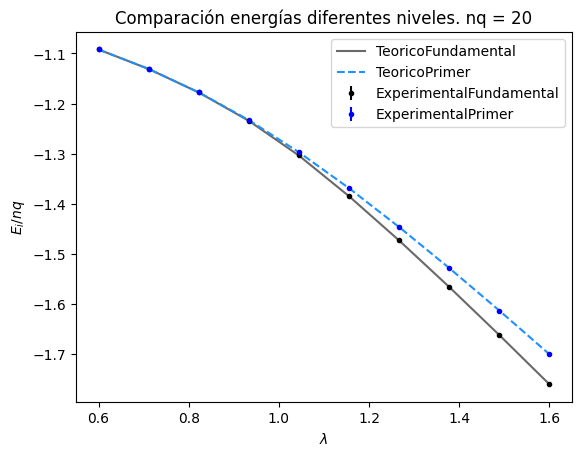

<Figure size 800x800 with 0 Axes>

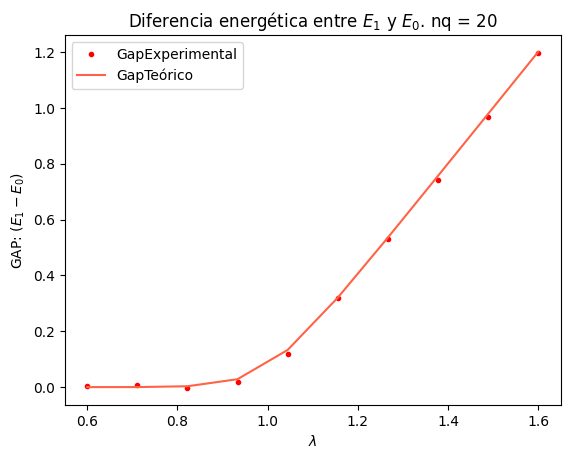

In [7]:
#Gráficas de las Energías
for nq in (valores_nq):
    """for nivel in ("Fundamental", "Primer"):
        with open('./DatosPruebas/EnergiasPrueba/%d/Energia_%s__%.2f-%.2f.txt' % (nq, nivel, landa_ini, landa_fin ), "r") as f, open('./Teoricos/%d/valoresTeoricos_%.2f-%.2f.txt' % (nq, landa_ini, landa_fin), "r") as g:
            lines = f.readlines()
            linesTeo = g.readlines()

            x = [float(line.split()[0]) for line in lines]
            y = [float(line.split()[1]) for line in lines]
            
            #print(y)
            E_teo_fund = [float(line.split()[1]) for line in linesTeo]
            E_teo_primer = [float(line.split()[2]) for line in linesTeo]
            #print(E_teo_primer)
            fig = plt.figure(figsize = (8, 8))     
            fig, ax = plt.subplots()
            ax.errorbar(x, y, yerr = 1/np.sqrt(nshots), marker = '.', linestyle = 'none', color = 'blue', label = 'Simulación%s' % (nivel))
            if nivel == "Fundamental" :
                ax.set_title(f'$%s;  E_0/nq; nq=%d; Trotter=%d$' % (nivel, nq, trotter))
                ax.set_ylabel(f'$E_0/nq$')
                ax.plot(x, E_teo_fund, color = 'black', label = 'Teórico%s' % (nivel))
           
            elif nivel == "Primer":               
                ax.set_title(f'%s;  E_1/nq; nq=%d; Trotter=%d' % (nivel, nq, trotter))
                ax.set_ylabel(f'$E_1/nq$')
                ax.plot(x, E_teo_primer, linestyle = "dashed", color = 'dodgerblue', label = 'Teórico%s' % (nivel))
            
            ax.legend()
            ax.set_xlabel(f'$\lambda$') # type: ignore
            
            plt.savefig("./DatosPruebas/EnergiasPrueba/%d/Grafica_%dN_%s__%.2f-%.2f.pdf" % (nq, nq, nivel, landa_ini, landa_fin), format = "pdf", bbox_inches = "tight")
            #plt.show()
        """
    with open(f'./DatosPruebas/EnergiasPrueba/{nq}/Energia_Fundamental__{landa_ini:.2f}-{landa_fin:.2f}.txt', "r") as FundExpFile, open(f'./DatosPruebas/EnergiasPrueba/{nq}/Energia_Primer__{landa_ini:.2f}-{landa_fin:.2f}.txt', "r") as PrimerExpFile, open(f'./Teoricos/{nq}/valoresTeoricos_{landa_ini:.2f}-{landa_fin:.2f}.txt', "r") as TeoFile:
        linesFund = FundExpFile.readlines()
        linesPrimer = PrimerExpFile.readlines()
        linesTeo = TeoFile.readlines()


        landasgrafica = [float(line.split()[0]) for line in linesFund]

        E_fundexp_grafica = [float(line.split()[1]) for line in linesFund]
        E_fundteo_grafica = [float(line.split()[1]) for line in linesTeo]

        E_primerexp_grafica = [float(line.split()[1]) for line in linesPrimer]
        E_primerteo_grafica = [float(line.split()[2]) for line in linesTeo]

        figura2 = plt.figure(figsize = (8, 8))
        figura2, Conjunta = plt.subplots()

        Conjunta.errorbar(landasgrafica, E_fundexp_grafica, yerr = 1/np.sqrt(nshots), marker =".", linestyle = "none", color = "black", label = "ExperimentalFundamental")
        Conjunta.plot(landasgrafica, E_fundteo_grafica, linestyle = "solid", color = "dimgrey", label = "TeoricoFundamental")

        Conjunta.errorbar(landasgrafica, E_primerexp_grafica, yerr = 1/np.sqrt(nshots), marker =".", linestyle = "none", color = "blue", label = "ExperimentalPrimer")
        Conjunta.plot(landasgrafica, E_primerteo_grafica, linestyle = "dashed", color = "dodgerblue", label = "TeoricoPrimer")

        Conjunta.set_title(f"Comparación energías diferentes niveles. nq = {nq}")
        Conjunta.legend()
        Conjunta.set_xlabel(f'$\lambda$') # type: ignore
        Conjunta.set_ylabel(f'$E_i/nq$')

        plt.savefig(f"./DatosPruebas/EnergiasPrueba/{nq}/GraficaEnergias_{nq}N_{landa_ini:.2f}-{landa_fin:.2f}.pdf", format = "pdf", bbox_inches = "tight")

        #Graficamos el GAP entre E1 y E0
        figura3 = plt.figure(figsize = (8,8))
        figura3, GAPgrafica = plt.subplots()

        gap_teo = [float(line.split()[3]) for line in linesTeo]
        GAP = []
        for i in range(len(E_primerexp_grafica)):
            GAP.append(nq*(E_primerexp_grafica[i] - E_fundexp_grafica[i]))
        
        GAPgrafica.plot(landasgrafica, GAP, linestyle = "None", marker = ".", color = "red", label = "GapExperimental")
        GAPgrafica.plot(landasgrafica, gap_teo, linestyle = "solid", color = "tomato", label = "GapTeórico")
        
        GAPgrafica.set_title(f'Diferencia energética entre $E_1$ y $E_0$. nq = {nq}')
        GAPgrafica.set_xlabel(f'$\lambda$') # type: ignore
        GAPgrafica.set_ylabel(f'GAP: $(E_1 - E_0)$')
        GAPgrafica.legend()

        plt.savefig(f"./DatosPruebas/DiferenciaEnergiasPrueba/GAP_{nq}N_{landa_ini:.2f}-{landa_fin:.2f}.pdf", format = "pdf", bbox_inches = "tight")
    plt.show()

In [ ]:
"""Guardamos los datos de simulación en un fichero de texto""" 
#if SUCCESSFUL: 
#with open("./RegistroSimulaciones.txt", "w") as f:
#        f.write("%s\n Hora comienzo: %s\nHora Final: %s\nTrotter: %d\nSteps: %d\n Qubits: %d " % (f, COMIENZO, FIN, trotter, numTiempos, valores_nq[0]))

'Guardamos los datos de simulación en un fichero de texto'